In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
import regex as re

The dataset contains 8k images, which is already split into 6k for training, 1k for validation and 1k for testing. Each image has 5 captions associated with it. 
We read tokenised dataset which contains data in form: 
**img_id caption# caption**

In [ ]:
# Function to read file containing captions associated to images
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [ ]:
captions = readTextFile("/content/drive/My Drive/Image-Captioning/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [ ]:
len(captions.split("\n"))

40461

In [ ]:
captions = captions.split('\n')[:-1] #last is an empty line

In [ ]:
captions[0]


'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [ ]:
#Dictionary to store captions against image ID
descriptions = {}

for x in captions:
  first,second = x.split('\t')
  img_name = first.split('.')[0]

  #if img_id present or not
  if descriptions.get(img_name) is None:
    descriptions[img_name] = []

  descriptions[img_name].append(second)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

<function matplotlib.pyplot.show>

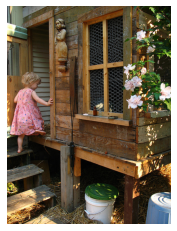

In [ ]:

IMG_PATH = "/content/drive/My Drive/Image-Captioning/Flickr_Data/Flickr_Data/Images/"
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show


# DATA CLEANING

We won't remove stopwords as we need the stopwords for caption and also stemming must not be done as we need gramatically english text.<br>
Possibilities:<br>
Convert to lowercase<br>
Remove numbers, punctutations, special characters<br>
Reduce Vocab size as reducing this will decrease no of neurons and thus prevent overfitting, faster training


In [ ]:
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = re.sub("[^a-z]+"," ",sentence)
  sentence = sentence.split()

  sentence = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)
  return sentence  

In [ ]:
clean_text("A cat is sitting on 64")

'cat is sitting on'

In [ ]:
for key,caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
#Write data to text file
with open('descriptions.txt','w') as f:
  f.write(str(descriptions))


# Vocabulary

In [ ]:
descriptions = None
with open ('descriptions.txt','r') as f:
  descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)


In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
#Vocab

vocab = set()
for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]] #for sentences in dictionary, splitting and passing the list of words to set
print("Vocab Size : %d"%len(vocab))

Vocab Size : 8424


In [ ]:
total_words = []
for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key] for i in des.split()]

print(len(total_words))

373837


In [ ]:
# counting frequencies to keep words occuring more than threshold value of 10
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys())) 

8424


In [ ]:
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]
print(len(total_words)) 

1845


# Prepare Train/Test Data
We have descriptions of all images. train and test. And we have train images and test images divided from before. So, we will prepare training descriptions data.

In [ ]:
f_tr = open("/content/drive/My Drive/Image-Captioning/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt","r")
train_file_data = f_tr.read()
f_te = open("/content/drive/My Drive/Image-Captioning/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt","r")
test_file_data = f_te.read()


In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
#Preparing Descriptions for training data
#Tweak - add start and end token to training data to teach the model the start and end of sentences

train_descriptions = {}
for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = "<s> " + cap + " <e>"
    train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>']

# Transfer Learning
Convert Images to Features<br>
Convert Text to Features


# Step-1 Image Feature Extraction

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [ ]:
model_new = Model(model.input, model.layers[-2].output)


In [ ]:
def preprocess_img(img):
  img = image.load_img(img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0) #ResNet accepts 4D Tensor, this converts (224,224,3) to (1,224,224,3), can use reshape also
  #Normalization
  img = preprocess_input(img)
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


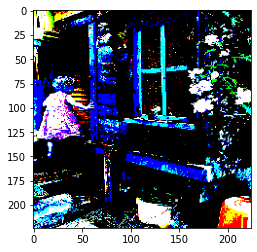

In [ ]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()


In [ ]:
def encode_img(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((2048,))
  return feature_vector


In [ ]:
start = time()
encoding_train = {}
#image_id ---> feature_vector extracted from ResNet 

for ix,img_id in enumerate(train):
  img_path = IMG_PATH+"/"+img_id+".jpg"
  encoding_train[img_id] = encode_img(img_path)

  if(ix%100==0):
    print("Encoding in Progress Time Step %d"%ix)

end_t = time()
print("Total Time:",end_t-start) 

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [ ]:
#Store data on disk using Pickle
with open("encoded_train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)

In [ ]:
encoding_test = {}
#image_id ---> feature_vector extracted from ResNet 

for ix,img_id in enumerate(test):
  img_path = IMG_PATH+"/"+img_id+".jpg"
  encoding_test[img_id] = encode_img(img_path)

  if(ix%100==0):
    print("Test Encoding in Progress Time Step %d"%ix)


with open("encoded_test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

Test Encoding in Progress Time Step 0
Test Encoding in Progress Time Step 100
Test Encoding in Progress Time Step 200
Test Encoding in Progress Time Step 300
Test Encoding in Progress Time Step 400
Test Encoding in Progress Time Step 500
Test Encoding in Progress Time Step 600
Test Encoding in Progress Time Step 700
Test Encoding in Progress Time Step 800
Test Encoding in Progress Time Step 900


In [ ]:
with open("encoded_test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i+1 #i+1, because we reserve 0 index when word is not there.
  idx_to_word[i+1] = word

In [ ]:
#Two special words <s> and <e> need to be added into the dictionary
idx_to_word[1846] = '<s>'
word_to_idx['<s>'] = 1846

idx_to_word[1847] = '<e>'
word_to_idx['<e>'] = 1847

vocab_size = len(word_to_idx)+1
print("Vocab Size:", vocab_size)

Vocab Size: 1848


In [ ]:
#Find maximum length of description to know how may times do we unroll our RNN/LSTM
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len,len(cap.split()))

print(max_len)

35


#Data Loader(Generator)

In [ ]:
pwd

'/content/drive/My Drive/Image-Captioning'

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  X1,X2,y = [],[],[]
  n=0
  while True:
    for key, desc_list in train_descriptions.items():
      n+=1

      photo = encoding_train[key]
      for desc in desc_list:  
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # padding done to match the max length of the caption
          yi = to_categorical([yi], num_classes=vocab_size)[0]

          X1.append(photo)
          X2.append(xi)
          y.append(yi)
      
        if n==batch_size:
          yield [[np.array(X1),np.array(X2)],np.array(y)] #generator function remembers the state of lsast function call

          X1,X2,y = [],[],[] #initialise empty list again after function call, control comes back to generator function
          n=0

# Word Embeddings(Transfer Learning)

Embedding done into Glove Vectors of 50 dim size

In [ ]:
f = open("/content/drive/My Drive/kaggle/glove.6B.50d.txt", encoding='utf-8')

In [ ]:
embedding_index = {}

for line in f:
  values = line.split()

  word = values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding


In [ ]:
def get_embedding_matrix():
  emb_dim=50
  matrix = np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector
  return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape


(1848, 50)

In [ ]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

# Model Architecture


In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)



In [ ]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model = Model(inputs=[input_img_features,input_captions], outputs=outputs)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 35, 50)       92400       input_11[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2048)         0           input_10[0][0]                   
____________________________________________________________________________________________

In [ ]:
#Embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training Model


In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
with open("/content/drive/My Drive/Image-Captioning/encoded_train_features.pkl",'rb') as f:
  encoding_train = pickle.load(f)
with open("/content/drive/My Drive/Image-Captioning/encoded_test_features.pkl",'rb') as t:
  encoding_test = pickle.load(t)

In [ ]:
def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
train()

Epoch 1/1
 560/2000 [=======>......................] - ETA: 4:38 - loss: 2.3721

KeyboardInterrupt: ignored

In [ ]:
def predict_caption(photo):
  in_text='<s>'
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax() #word with max. probability
    word = idx_to_word[ypred]
    in_text+=(' ' + word)
    

    if word == '<e>':
      break

  final_caption = in_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  
  return final_caption


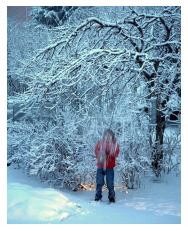

little girl in pink hat is walking on the sidewalk


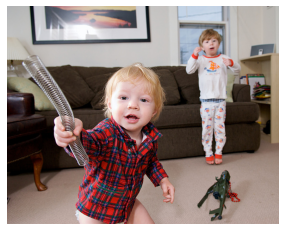

two children are playing on bed


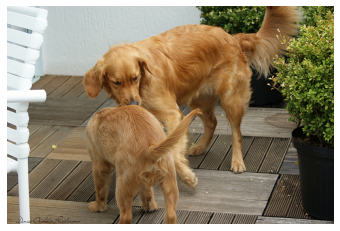

brown dog is running on the sidewalk


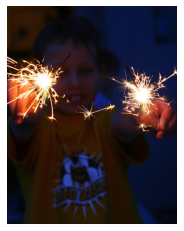

woman in green shirt is playing guitar


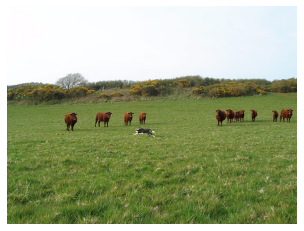

two dogs are running on the grass


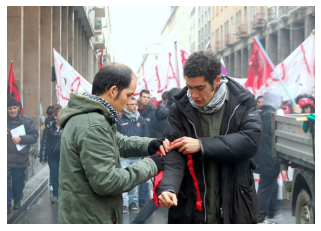

man in blue shirt and tie talks to woman in black


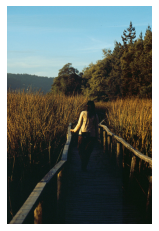

man and woman are standing on the edge of the edge of lake


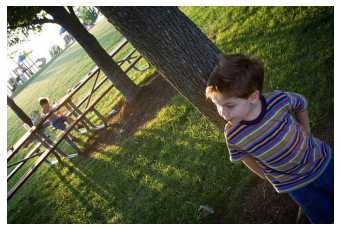

little girl in pink shirt is hanging upside down from jungle gym


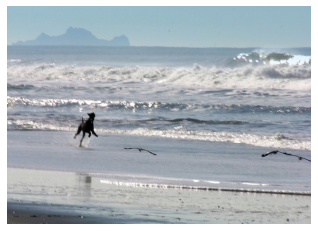

person doing on beach


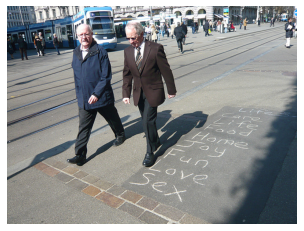

man in blue shirt walks down sidewalk near street


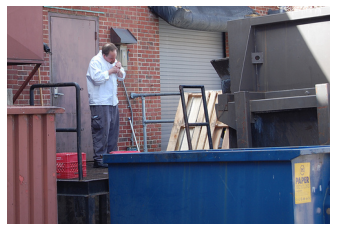

man in black shirt is standing next to an man who is sitting on the ground


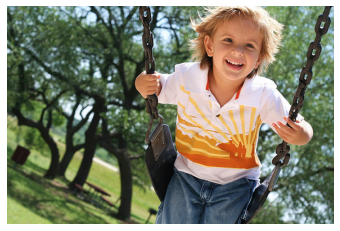

two girls in shirts and khaki are standing on grass


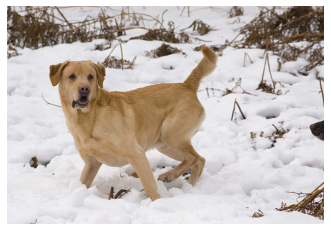

dog in the snow carries stick in its mouth


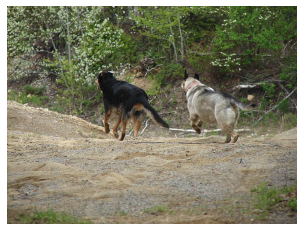

two dogs are wrestling in the grass


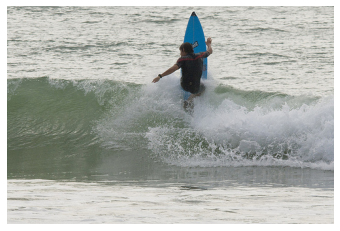

man in black shirt fishes in the ocean


In [ ]:
for i in range(15):
  idx = np.random.randint(0,1000)
  all_img_names = list(encoding_test.keys())
  img_name = all_img_names[idx]
  photo_2048 = encoding_test[img_name].reshape((1,2048))

  i = plt.imread(IMG_PATH+img_name+'.jpg')
  caption = predict_caption(photo_2048)
  plt.imshow(i)
  plt.axis('off')
  plt.show()
  print(caption)
  